In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

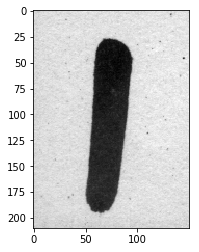

In [2]:
def minimos(valores, umbral=0.3):
    """ A partir de un vector de valores y un umbral busca 
        los minimos estimados de la curva. Detecta un mínimo 
        para cada vez que la curva baja del valor del 'umbral'
        (punto i1) y luego vuelve a subir por encima de 'umbral'
        (punto i2). Cada vez que occurre esto marca el punto 
        mínimo como el punto medio entre i1 e i2
    """
    zonas_picos = valores>umbral
    
    cuts = []
    i1 = 0
    while True:
        if i1 >= len(zonas_picos)-1:
            break
        if zonas_picos[i1] == True and zonas_picos[i1+1] == False:
            for i2 in range(i1+1, len(zonas_picos)-1):
                if zonas_picos[i2] == False and zonas_picos[i2+1] == True:
                    cuts.append(int(0.5+i1+(i2-i1)/2))
                    i1 = i2
                    break
                    
        i1 = i1 + 1

    return cuts

def detectar_lineas(imagen):
    """ Devuelve las parejas de posiciones en la imagen que 
        corresponden con los cortes que vamos a hacer. Cada 
        pareja indica el pixel inicio y final del corte. Entre 
        medias está la imagen de la celda
        Devuelve dos listas: una con los cortes horizontales y
        otra con los verticales
        Eliminamos la primera columna y las dos primeras filas
    """
    acumulado_v = np.sum(imagen, axis=0)/255/imagen.shape[0]
    acumulado_h = np.sum(imagen, axis=1)/255/imagen.shape[1]

    cortes_v = minimos(acumulado_v)
    cortes_h = minimos(acumulado_h)
    
    #Eliminamos la primera columna y las dos primeras filas
    cortes_v.pop(0)
    cortes_h.pop(0)
    cortes_h.pop(0)
    
    return [(ini,fin) for ini,fin in zip(cortes_h[:-1],cortes_h[1:])], \
           [(ini,fin) for ini,fin in zip(cortes_v[:-1],cortes_v[1:])]
    
def extrae_cuadradito(imagen, corte_h, corte_v, alto, ancho):
    """ Extrae un recuadro de alto y ancho de la 'imagen'.
        El recuadro se extrae dentro de las coordenadas 
        definidas con corte_v (vertical) y corte_h (horizontal).
        Elimina los márgenes alrededor
    """
    assert corte_h[1]-corte_h[0]+1 >= alto,  "Alto demasiado grande"
    assert corte_v[1]-corte_v[0]+1 >= ancho, "Ancho demasiado grande"
    
    margen_h = (corte_h[1] - corte_h[0] + 1 - alto)
    margen_v = (corte_v[1] - corte_v[0] + 1 - ancho)
    
    h0 = int(corte_h[0] +  margen_h // 2)
    h1 = int(corte_h[1] - (margen_h // 2 if margen_h % 2 == 0 else (1 + margen_h // 2)))
    v0 = int(corte_v[0] +  margen_v // 2)
    v1 = int(corte_v[1] - (margen_v // 2 if margen_v % 2 == 0 else (1 + margen_v // 2)))
    
    assert h1-h0+1==alto,  "H:{}-V:{}-C{}".format(corte_h, corte_v,[h0,h1])
    assert v1-v0+1==ancho, "H:{}-V:{}-C{}".format(corte_h, corte_v,[v0,v1])
    
    return imagen[h0:h1+1, v0:v1+1]

def test():
    imagen = mpimg.imread('imagenes/out-0032.png', True)
    h, v = detectar_lineas(imagen)
    plt.imshow(extrae_cuadradito(imagen,h[np.random.randint(2,13)],v[np.random.randint(2,11)],210,150),cmap='gray')
    
test()

In [3]:
def extrae_celdas(nombres_imagenes, alto, ancho):
    """ A partir de una lista de imágenes extrae las celdas
        todas con un mismo alto y ancho
    """
    
    celdas = []
    for nombre_imagen in nombres_imagenes:
        imagen             = mpimg.imread(nombre_imagen, True)
        
        cortes_h, cortes_v = detectar_lineas(imagen)
        
        celdas.extend([extrae_cuadradito(imagen, corte_h, corte_v, alto, ancho) \
                                                     for corte_h in cortes_h \
                                                     for corte_v in cortes_v])
    
    return celdas

def guarda_celdas(celdas, clases, out_dir='imagenes/out'):
    """ Guarda las imágenes de cada celda en fichero 
        en el directorio out
    """
    from scipy import misc
    
    for i, celda in enumerate(celdas):
        misc.toimage(celda).save(out_dir + '/l{:05d}_{}.png'.format(i,clases[i%len(clases)]))
        
def mostrar_imagenes(imagenes):
    """ Muestra en un grid las imágenes """
    n_filas = 1+len(imagenes)//10
    plt.figure( figsize = (n_filas,10) )
    for i, img in enumerate(imagenes):
        plt.subplot(n_filas,10,i+1)
        plt.imshow(img, cmap='gray')
    
def parametros_por_defecto():
    """ Devuelve los parámetros por defecto.
        Se pueden crear nuevas funciones con otros
        parametros
    """
    import glob
    
    nombres_imagenes = glob.glob('*png')
    alto             = 206
    ancho            = 150
    clases           = 'ABCDEFGHIJ'
    
    return nombres_imagenes, alto, ancho, clases
 
def run(get_params=parametros_por_defecto):
    """ Recorre todas las imágenes, extrae las celdas y guarda
        el resultado en ficheros de imagen individuales
    """
    
    nombres_imagenes, \
    alto,             \
    ancho,            \
    clases           = get_params()
    
    celdas = extrae_celdas(nombres_imagenes, alto, ancho)
    
    guarda_celdas(celdas, clases, 'imagenes/out')
        
    return np.array(celdas)

In [4]:
celdas = run(parametros_por_defecto)

#Muestra la primera hoja
mostrar_imagenes(celdas[:110])

#Muestra 110 al azar
#mostrar_imagenes(celdas[np.random.randint(0,len(celdas),110,dtype=int)])

<Figure size 72x720 with 0 Axes>